# Cenário 1: 2 qubits e 1 alvo

- Objetivo: Validar o funcionamento em baixa escala ao verificar se o estado alvo aparece com alta probabilidade nas medições. 

Neste cenário, usamos:
- Número de qubits: $n = 2$
- Espaço de busca: $N = 2^n = 4$
- Número de alvos: $M = 1$
- Alvo: $|11\rangle$

O número ideal de iterações de Grover é:
$$
k \approx \left\lfloor \frac{\pi}{4}\sqrt{\frac{N}{M}} \right\rfloor
$$

## Implementação do Algoritmo de Grover para o Cenário 1

In [ ]:
# =================================================
# Funções auxiliares para a construção do algoritmo
# =================================================

import math
from qiskit import QuantumCircuit

# Função para calcular o número ideal de iterações de Grover
def grover_iterations(n: int, m: int) -> int:
    """
    Calcula o número ideal de iterações do algoritmo de Grover.

    A aproximação usada é:

    $$
    k \\approx \\left\\lfloor \\frac{\\pi}{4}\\sqrt{\\frac{N}{M}} \\right\\rfloor
    $$

    onde $$N = 2^n$$ e $$M$$ é o número de alvos.

    Parameters
    ----------
    n : int
        Número de qubits.
    m : int
        Número de estados-alvo (soluções).

    Returns
    -------
    int
        Número de iterações k.
    """
    if n < 1:
        raise ValueError("n deve ser >= 1.")
    if m < 1:
        raise ValueError("m deve ser >= 1.")
    N = 2**n
    return int(math.floor((math.pi / 4) * math.sqrt(N / m)))

# Função para criar o oráculo de fase para 2 qubits
def oracle_phase_single_target(target: str) -> QuantumCircuit:
    """
    Cria um oráculo de fase que aplica -1 SOMENTE ao estado |target>.

    Implementação "na mão":
    - Aplica X nos qubits onde o alvo tem bit 0, para mapear |target> -> |11...1>
    - Aplica um MCZ (multi-controlled Z) em |11...1>
      MCZ é implementado como: H(no último) + MCX + H(no último)
    - Desfaz os X

    Parameters
    ----------
    target : str
        String binária com n bits, por exemplo: "11" (n=2), "0101" (n=4).
        O índice target[i] corresponde ao qubit i.

    Returns
    -------
    QuantumCircuit
        Circuito do oráculo de fase reutilizável.

    Notes
    -----
    - Para n=1, o oráculo vira simplesmente Z se target="1" (ou XZX para target="0").
    - Para n>=2, usamos MCX (que o transpiler decompõe quando necessário).
    """
    if any(b not in "01" for b in target):
        raise ValueError("target deve conter apenas '0' e '1'.")

    n = len(target)
    qc = QuantumCircuit(n, name=f"Oracle({target})")

    # Mapear |target> -> |11..1| aplicando X onde target tem 0
    for i, bit in enumerate(target):
        if bit == "0":
            qc.x(i)

    # Aplicar -1 em |11..1| via MCZ:
    # MCZ = H(last) · MCX(controls=0..n-2, target=n-1) · H(last)
    qc.h(n - 1)

    if n == 1:
        qc.z(0)
    elif n == 2:
        qc.cx(0, 1)
    else:
        controls = list(range(n - 1))
        qc.mcx(controls, n - 1)

    qc.h(n - 1)

    # Desfazer mapeamento
    for i, bit in enumerate(target):
        if bit == "0":
            qc.x(i)

    return qc

# Função para criar o difusor (operador de Grover)
def diffuser(n: int) -> QuantumCircuit:
    """
    Cria o operador de difusão (inversão sobre a média) para n qubits.

    Decomposição padrão:

        D = H^{⊗n} · X^{⊗n} · MCZ · X^{⊗n} · H^{⊗n}

    e MCZ é implementado como:

        MCZ = H(no último qubit) · MCX(controles=0..n-2, alvo=n-1) · H(no último qubit)

    Parameters
    ----------
    n : int
        Número de qubits do registrador de busca.

    Returns
    -------
    QuantumCircuit
        Circuito do difusor reutilizável.
    """
    if n < 1:
        raise ValueError("n deve ser >= 1.")

    qc = QuantumCircuit(n, name=f"Diffuser({n}q)")

    qc.h(range(n))
    qc.x(range(n))

    qc.h(n - 1)
    if n == 1:
        qc.z(0)
    elif n == 2:
        qc.cx(0, 1)
    else:
        qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)

    qc.x(range(n))
    qc.h(range(n))

    return qc

# Função para montar o circuito completo do Grover
def build_grover_circuit(n: int, target: str, shots: int = 1024) -> tuple[QuantumCircuit, int]:
    """
    Monta o circuito completo do Grover (preparação + k iterações + medição).

    Parameters
    ----------
    n : int
        Número de qubits.
    target : str
        Estado alvo em binário (n bits).
    shots : int
        Apenas para manter o parâmetro do cenário organizado (não executa aqui).

    Returns
    -------
    (QuantumCircuit, int)
        O circuito final com medições e o número de iterações k.
    """
    if len(target) != n:
        raise ValueError("target deve ter exatamente n bits.")

    m = 1
    k = grover_iterations(n, m)

    oracle = oracle_phase_single_target(target)
    diff = diffuser(n)

    qc = QuantumCircuit(n, n, name=f"Grover(n={n}, target={target})")

    # 1) Preparação: superposição uniforme
    qc.h(range(n))

    # 2) k iterações: (oráculo + difusor)
    for _ in range(k):
        qc.compose(oracle, inplace=True)
        qc.compose(diff, inplace=True)

    # 3) Medições (bit clássico i recebe medida do qubit i)
    qc.measure(range(n), range(n))

    return qc, k

# Função para imprimir o resumo do cenário
def print_scenario_summary(
    scenario_id: int,
    n: int,
    target: str | list[str],
    shots: int,
    k: int
) -> None:
    """
    Imprime um resumo padronizado do cenário de execução do algoritmo de Grover.

    Parameters
    ----------
    scenario_id : int
        Identificador do cenário (ex.: 1, 2, 3, 4).
    n : int
        Número de qubits do registrador de busca.
    target : str or list[str]
        Estado alvo (binário) ou lista de estados alvo.
        Ex.: "11" ou ["001", "101"].
    shots : int
        Número de medições realizadas.
    k : int
        Número de iterações de Grover aplicadas.
    """
    if isinstance(target, list):
        target_str = ", ".join(f"|{t}>" for t in target)
    else:
        target_str = f"|{target}>"

    print(
        f"Cenário {scenario_id} -> "
        f"n={n}, "
        f"alvo(s)={target_str}, "
        f"shots={shots}, "
        f"iterações k={k}"
    )

In [19]:
# =========================================
# Construção do Circuito Quântico de Grover
# =========================================

n = 2
target = "11"  # você pode trocar por "00", "01", "10"
shots = 1024

grover_circuit, k = build_grover_circuit(n=n, target=target, shots=shots)

print_scenario_summary(
    scenario_id=1,
    n=n,
    target=target,
    shots=shots,
    k=k
)


Cenário 1 -> n=2, alvo(s)=|11>, shots=1024, iterações k=1


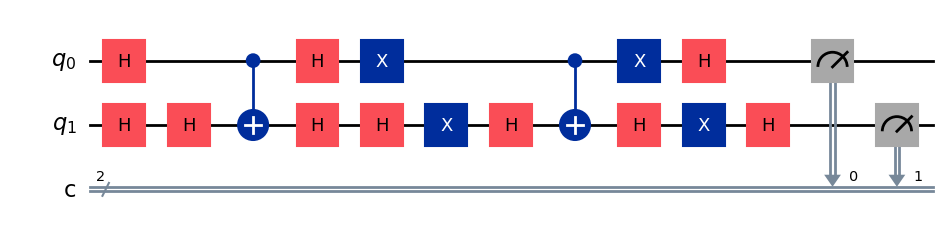

In [20]:
# Desenhar o circuito
grover_circuit.draw("mpl")

In [22]:
# =====================================================================
# Funções auxiliares para a execução do algoritmo em ambiente simulado
# =====================================================================

import time
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

# Função para executar a simulação quântica
def run_quantum_simulation(
    circuit,
    shots: int = 1024,
    optimization_level: int = 1
):
    """
    Executa a simulação quântica de um circuito usando AerSimulator.

    Parameters
    ----------
    circuit : QuantumCircuit
        Circuito quântico já contendo medições.
    shots : int
        Número de execuções (shots) da simulação.
    optimization_level : int
        Nível de otimização do transpiler (0 a 3).

    Returns
    -------
    dict
        Dicionário contendo:
        - counts: resultados das medições
        - execution_time: tempo total de execução (s)
        - shots: número de shots utilizados
    """
    simulator = AerSimulator()

    transpiled_circuit = transpile(
        circuit,
        simulator,
        optimization_level=optimization_level
    )

    start_time = time.perf_counter()
    job = simulator.run(transpiled_circuit, shots=shots)
    result = job.result()
    end_time = time.perf_counter()

    counts = result.get_counts()

    return {
        "counts": counts,
        "execution_time": end_time - start_time,
        "shots": shots
    }

# Função para calcular a probabilidade do estado alvo
def target_probability(counts: dict, target: str, shots: int) -> float:
    """
    Calcula a probabilidade empírica de medir o estado alvo.

    Parameters
    ----------
    counts : dict
        Dicionário retornado pela simulação (ex.: {'11': 980, '00': 44}).
    target : str
        Estado alvo em binário (ex.: '11').
    shots : int
        Número total de medições.

    Returns
    -------
    float
        Probabilidade do estado alvo.
    """
    return counts.get(target, 0) / shots

In [23]:
# Executar simulação
quantum_result = run_quantum_simulation(
    circuit=grover_circuit,
    shots=shots
)

counts = quantum_result["counts"]
exec_time = quantum_result["execution_time"]

# Probabilidade do estado alvo
p_target = target_probability(counts, target, shots)

print_scenario_summary(
    scenario_id=1,
    n=n,
    target=target,
    shots=shots,
    k=k
)

print(f"Tempo de execução (quântico): {exec_time:.6f} s")
print(f"Probabilidade do estado alvo |{target}>: {p_target:.4f}")

counts

Cenário 1 -> n=2, alvo(s)=|11>, shots=1024, iterações k=1
Tempo de execução (quântico): 0.004242 s
Probabilidade do estado alvo |11>: 1.0000


{'11': 1024}

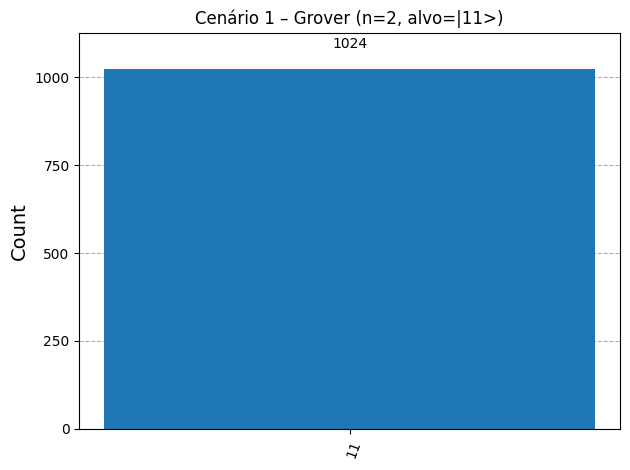

In [24]:
plot_histogram(
    counts,
    title=f"Cenário 1 – Grover (n={n}, alvo=|{target}>)"
)

## Implementação da Busca Clássica Linear para o Cenário 1



In [ ]:
# ===========================================================
# Funções auxiliares para implementar a busca linear clássica
# ===========================================================

import time

# Função para busca linear clássica
def linear_search(target: int, N: int) -> dict:
    """
    Executa uma busca linear clássica no intervalo [0, N-1] até encontrar o alvo.

    Parameters
    ----------
    target : int
        Valor alvo a ser encontrado.
    N : int
        Tamanho do espaço de busca (ex.: N = 2**n).

    Returns
    -------
    dict
        Dicionário contendo:
        - found_index: índice encontrado (ou None se não encontrado)
        - iterations: número de iterações realizadas
        - execution_time: tempo total de execução (s)
    """
    if N <= 0:
        raise ValueError("N deve ser > 0.")
    if target < 0 or target >= N:
        raise ValueError("target deve estar no intervalo [0, N-1].")

    start_time = time.perf_counter()

    iterations = 0
    found_index = None

    for x in range(N):
        iterations += 1
        if x == target:
            found_index = x
            break

    end_time = time.perf_counter()

    return {
        "found_index": found_index,
        "iterations": iterations,
        "execution_time": end_time - start_time
    }

# Função para converter string binária em inteiro
def bitstring_to_int(bitstring: str) -> int:
    """
    Converte uma string binária (ex.: '11') para inteiro.

    Parameters
    ----------
    bitstring : str
        String contendo apenas '0' e '1'.

    Returns
    -------
    int
        Valor inteiro correspondente.
    """
    if any(b not in "01" for b in bitstring):
        raise ValueError("bitstring deve conter apenas '0' e '1'.")
    return int(bitstring, 2)

In [28]:
N = 2**n
target_int = bitstring_to_int(target)

classic_result = linear_search(target=target_int, N=N)

print(f"Busca clássica linear -> alvo={target_int} (|{target}>), N={N}")
print(f"Tempo de execução (clássico): {classic_result['execution_time']:.8f} s")
print(f"Número de iterações (clássico): {classic_result['iterations']}")
print(f"Índice encontrado: {classic_result['found_index']}")

Busca clássica linear -> alvo=3 (|11>), N=4
Tempo de execução (clássico): 0.00000154 s
Número de iterações (clássico): 4
Índice encontrado: 3


## Comparações entre Grover e Busca Linear Clássica

In [ ]:
# ==========================================================================
# Funções auxiliares para a compração dos resultados quânticos vs clássicos
# ==========================================================================

# Função para comparar resultados quânticos vs clássicos
def compare_quantum_vs_classic(
    scenario_id: int,
    n: int,
    target: str,
    shots: int,
    k: int,
    quantum_result: dict,
    classic_result: dict
) -> dict:
    """
    Gera um mini-relatório comparando Grover (quântico) vs busca linear (clássica).

    Parameters
    ----------
    scenario_id : int
        Identificador do cenário (ex.: 1, 2, 3, 4).
    n : int
        Número de qubits.
    target : str
        Estado alvo em binário (n bits), ex.: "11".
    shots : int
        Número de shots da execução quântica.
    k : int
        Número de iterações de Grover aplicadas.
    quantum_result : dict
        Saída de run_quantum_simulation(...). Deve conter:
        - counts (dict)
        - execution_time (float)
        - shots (int)
    classic_result : dict
        Saída de linear_search(...). Deve conter:
        - execution_time (float)
        - iterations (int)
        - found_index (int | None)

    Returns
    -------
    dict
        Um dicionário com métricas consolidadas (útil para registro/relatório).
    """
    N = 2**n
    counts = quantum_result["counts"]
    tq = quantum_result["execution_time"]
    tc = classic_result["execution_time"]
    it_classic = classic_result["iterations"]
    found_index = classic_result["found_index"]

    p_target = counts.get(target, 0) / shots
    quantum_top = max(counts.items(), key=lambda kv: kv[1]) if counts else (None, 0)

    # Evitar divisão por zero (tempos podem ser muito pequenos em N pequeno)
    speedup = (tc / tq) if tq > 0 else float("inf")

    # Tempo médio aproximado por "operação"
    # - quântico: tempo total / k (uma iteração ≈ oráculo + difusão)
    # - clássico: tempo total / iterações (uma verificação)
    tq_per_iter = (tq / k) if k > 0 else tq
    tc_per_check = (tc / it_classic) if it_classic > 0 else tc

    print("=" * 65)
    print_scenario_summary(
        scenario_id=scenario_id,
        n=n,
        target=target,
        shots=shots,
        k=k
    )
    print("-" * 65)
    print(f"Espaço de busca: N = 2^n = {N}")
    print(f"Resultado quântico (tempo): {tq:.8f} s")
    print(f"Resultado clássico (tempo): {tc:.8f} s")
    print(f"Speedup (tc/tq): {speedup:.4f}  (valor > 1 favorece Grover)")
    print("-" * 65)
    print(f"Quântico -> P(|{target}>): {p_target:.4f}")
    print(f"Quântico -> estado mais frequente: |{quantum_top[0]}> com {quantum_top[1]}/{shots}")
    print("-" * 65)
    print(f"Clássico -> alvo (int): {int(target, 2)} | encontrado em: {found_index}")
    print(f"Clássico -> iterações: {it_classic}")
    print("-" * 65)
    print(f"Tempo médio por iteração de Grover: {tq_per_iter:.8f} s")
    print(f"Tempo médio por verificação clássica: {tc_per_check:.8f} s")
    print("=" * 65)

    return {
        "scenario_id": scenario_id,
        "n": n,
        "N": N,
        "target": target,
        "shots": shots,
        "k": k,
        "quantum_time_s": tq,
        "classic_time_s": tc,
        "speedup_tc_over_tq": speedup,
        "p_target": p_target,
        "quantum_counts": counts,
        "classic_iterations": it_classic,
        "classic_found_index": found_index,
        "quantum_time_per_grover_iter_s": tq_per_iter,
        "classic_time_per_check_s": tc_per_check,
    }

In [31]:
summary = compare_quantum_vs_classic(
    scenario_id=1,
    n=n,
    target=target,
    shots=shots,
    k=k,
    quantum_result=quantum_result,
    classic_result=classic_result
)

Cenário 1 -> n=2, alvo(s)=|11>, shots=1024, iterações k=1
-----------------------------------------------------------------
Espaço de busca: N = 2^n = 4
Resultado quântico (tempo): 0.00424187 s
Resultado clássico (tempo): 0.00000154 s
Speedup (tc/tq): 0.0004  (valor > 1 favorece Grover)
-----------------------------------------------------------------
Quântico -> P(|11>): 1.0000
Quântico -> estado mais frequente: |11> com 1024/1024
-----------------------------------------------------------------
Clássico -> alvo (int): 3 | encontrado em: 3
Clássico -> iterações: 4
-----------------------------------------------------------------
Tempo médio por iteração de Grover: 0.00424187 s
Tempo médio por verificação clássica: 0.00000039 s


In [43]:
# ==========================================================
# Funções auxiliares para a geração de gráficos comparativos
# ==========================================================

import matplotlib.pyplot as plt

# Função para plotar comparação de tempos
import matplotlib.pyplot as plt

def plot_time_comparison(
    quantum_time_s: float,
    classic_time_s: float,
    title: str = "",
    log_scale: bool = True
):
    """
    Gera um gráfico de barras comparando tempo total (quântico vs clássico).

    Quando log_scale=True, o eixo Y é logarítmico, evitando que valores
    muito pequenos (ex.: clássico) desapareçam visualmente.

    Parameters
    ----------
    quantum_time_s : float
        Tempo total da execução quântica (s).
    classic_time_s : float
        Tempo total da busca clássica (s).
    title : str
        Título opcional do gráfico.
    log_scale : bool
        Se True, usa escala logarítmica no eixo Y.
    """
    labels = ["Quântico (Grover)", "Clássico (Linear)"]
    values = [quantum_time_s, classic_time_s]

    plt.figure()
    plt.bar(labels, values)
    plt.ylabel("Tempo (s)")
    plt.title(title or "Comparação de tempo total")

    if log_scale:
        plt.yscale("log")
        plt.ylabel("Tempo (s) [escala log]")

    plt.xticks(rotation=10)
    plt.tight_layout()
    plt.show()

# Função para plotar comparação de contagem de operações
def plot_operation_count_comparison(k: int, classic_iterations: int, title: str = ""):
    """
    Gera um gráfico de barras comparando quantidade de 'operações':
    - quântico: número de iterações de Grover (k)
    - clássico: número de verificações até encontrar o alvo

    Parameters
    ----------
    k : int
        Número de iterações de Grover.
    classic_iterations : int
        Número de iterações/verificações da busca clássica.
    title : str
        Título opcional do gráfico.
    """
    labels = ["Iterações Grover (k)", "Verificações clássicas"]
    values = [k, classic_iterations]

    plt.figure()
    plt.bar(labels, values)
    plt.ylabel("Quantidade")
    plt.title(title or "Comparação do número de operações")
    plt.xticks(rotation=10)
    plt.tight_layout()
    plt.show()

# Função para plotar comparação de custo médio
def plot_avg_cost_comparison(
    quantum_time_s: float,
    classic_time_s: float,
    k: int,
    classic_iterations: int,
    title: str = "",
    log_scale: bool = True
):
    """
    Gera um gráfico de barras comparando o custo médio:
    - quântico: tempo médio por iteração de Grover (oráculo + difusão)
    - clássico: tempo médio por verificação

    Quando log_scale=True, o eixo Y é logarítmico, permitindo comparar
    valores com ordens de grandeza diferentes.

    Parameters
    ----------
    quantum_time_s : float
        Tempo total quântico (s).
    classic_time_s : float
        Tempo total clássico (s).
    k : int
        Número de iterações de Grover.
    classic_iterations : int
        Número de verificações da busca clássica.
    title : str
        Título opcional do gráfico.
    log_scale : bool
        Se True, usa escala logarítmica no eixo Y.
    """
    avg_quantum = (quantum_time_s / k) if k > 0 else quantum_time_s
    avg_classic = (classic_time_s / classic_iterations) if classic_iterations > 0 else classic_time_s

    labels = ["Quântico: tempo/iteração", "Clássico: tempo/verificação"]
    values = [avg_quantum, avg_classic]

    plt.figure()
    plt.bar(labels, values)
    plt.title(title or "Comparação de custo médio por operação")

    if log_scale:
        plt.yscale("log")
        plt.ylabel("Tempo médio (s) [escala log]")
    else:
        plt.ylabel("Tempo médio (s)")

    plt.xticks(rotation=10)
    plt.tight_layout()
    plt.show()

# Função para plotar taxa de sucesso quântica
def plot_quantum_success_rate(
    counts: dict,
    target: str,
    shots: int,
    title: str = "",
    log_scale: bool = False
):
    """
    Gera um gráfico de barras da taxa de sucesso quântica:
    - estado alvo vs estados não-alvo

    Quando log_scale=True, o eixo Y é logarítmico, útil para
    grandes números de shots ou diferenças muito grandes.

    Parameters
    ----------
    counts : dict
        Dicionário de contagens (ex.: {'11': 980, '00': 44}).
    target : str
        Estado alvo (ex.: '11').
    shots : int
        Total de shots.
    title : str
        Título opcional do gráfico.
    log_scale : bool
        Se True, usa escala logarítmica no eixo Y.
    """
    target_hits = counts.get(target, 0)
    non_target_hits = shots - target_hits

    labels = [f"Alvo |{target}>", "Não-alvo (restante)"]
    values = [target_hits, non_target_hits]

    plt.figure()
    plt.bar(labels, values)
    plt.title(title or "Taxa de sucesso quântico")

    if log_scale:
        plt.yscale("log")
        plt.ylabel("Contagens [escala log]")
    else:
        plt.ylabel("Contagens")

    plt.xticks(rotation=10)
    plt.tight_layout()
    plt.show()

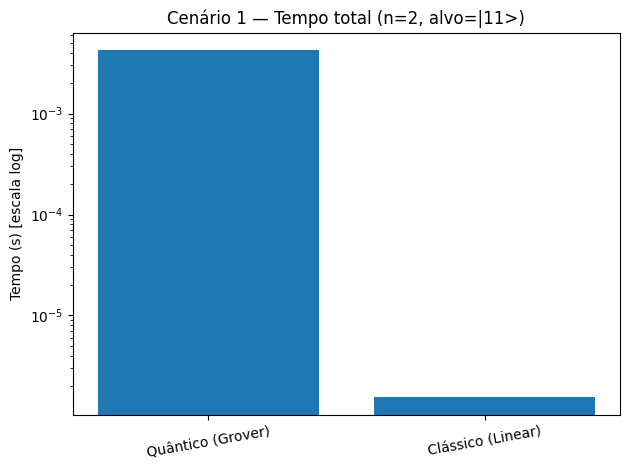

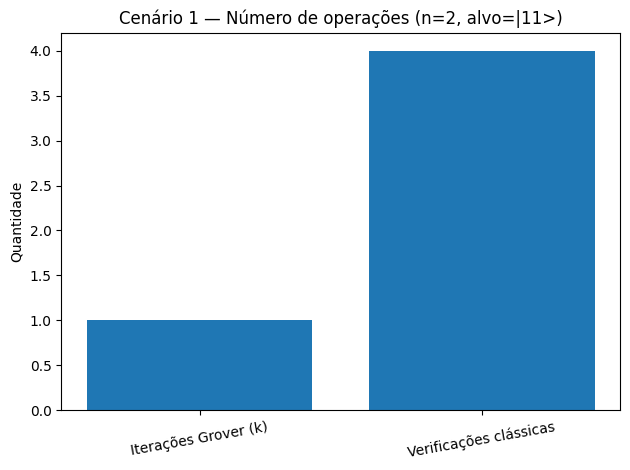

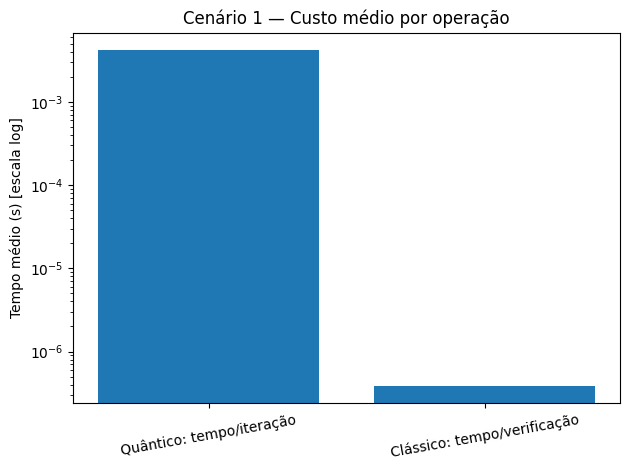

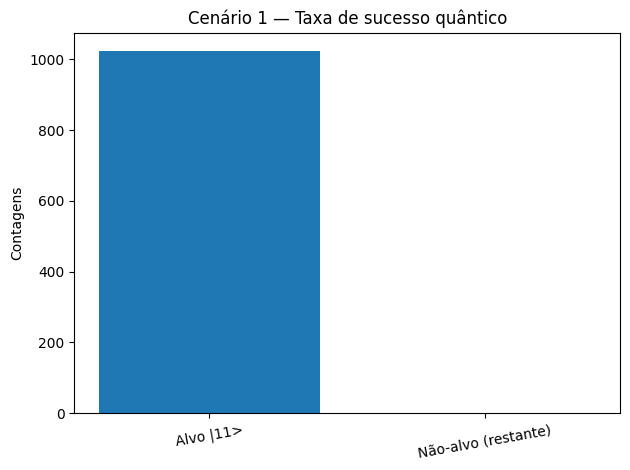

In [44]:
plot_time_comparison(
    quantum_time_s=quantum_result["execution_time"],
    classic_time_s=classic_result["execution_time"],
    title=f"Cenário 1 — Tempo total (n={n}, alvo=|{target}>)"
)

plot_operation_count_comparison(
    k=k,
    classic_iterations=classic_result["iterations"],
    title=f"Cenário 1 — Número de operações (n={n}, alvo=|{target}>)"
)

plot_avg_cost_comparison(
    quantum_time_s=quantum_result["execution_time"],
    classic_time_s=classic_result["execution_time"],
    k=k,
    classic_iterations=classic_result["iterations"],
    title="Cenário 1 — Custo médio por operação",
    log_scale=True
)

plot_quantum_success_rate(
    counts=quantum_result["counts"],
    target=target,
    shots=shots,
    title="Cenário 1 — Taxa de sucesso quântico",
    log_scale=False  # normalmente linear aqui
)

## Discussão

No Cenário 1, foi implementado o algoritmo de Grover em sua configuração mais simples, utilizando um registrador de busca composto por $ n = 2 $ qubits, o que resulta em um espaço de busca de tamanho $ N = 2^n = 4 $. O objetivo deste cenário é validar o correto funcionamento do circuito quântico em pequena escala, servindo como um experimento de verificação conceitual antes de avançar para configurações maiores.

O circuito quântico foi construído a partir de três componentes fundamentais: (i) a preparação do estado inicial em superposição uniforme por meio da aplicação da porta de Hadamard em todos os qubits; (ii) o oráculo de fase, responsável por marcar o estado alvo $ |11\rangle $ com uma inversão de fase; e (iii) o operador de difusão, que realiza a inversão das amplitudes em torno da média, amplificando a probabilidade do estado marcado. Para este cenário, o número ideal de iterações de Grover, calculado pela expressão  

$$
k \approx \left\lfloor \frac{\pi}{4}\sqrt{\frac{N}{M}} \right\rfloor
$$

com $ M = 1 $, resultou em $ k = 1 $, em concordância com a formulação teórica do algoritmo.

Os resultados quânticos obtidos confirmam o comportamento esperado. Após a execução do circuito com 1024 shots, o estado alvo $ |11\rangle $ foi medido em 100% das execuções, resultando em uma probabilidade empírica $ P(|11\rangle) = 1.0 $. Esse resultado evidencia que, para um espaço de busca reduzido, uma única iteração de Grover é suficiente para concentrar completamente a amplitude no estado marcado, validando tanto a implementação do oráculo quanto do operador de difusão.

Entretanto, ao comparar o desempenho temporal com a busca clássica linear, observa-se uma clara desvantagem do algoritmo quântico neste cenário. Enquanto a execução quântica apresentou um tempo total de aproximadamente $ 4{,}24 \times 10^{-3} $ segundos, a busca clássica encontrou o alvo em cerca de $ 1{,}54 \times 10^{-6} $ segundos, realizando apenas quatro verificações. O fator de speedup calculado ($ tc/tq \approx 0{,}0004 $) indica que, para valores pequenos de $ N $, o custo de execução do circuito quântico supera amplamente o custo da busca clássica.

Essa diferença é explicada pelo overhead inerente à computação quântica em ambientes simulados, que inclui etapas como transpilation, simulação de portas quânticas e coleta estatística das medições. Mesmo considerando o custo médio por operação, a iteração de Grover (oráculo + difusão) apresenta um tempo significativamente maior do que uma única verificação clássica. Assim, embora o algoritmo de Grover reduza o número de consultas ao oráculo de $ O(N) $ para $ O(\sqrt{N}) $, essa vantagem assintótica não se manifesta em espaços de busca pequenos.

Em síntese, o Cenário 1 cumpre seu papel de validação funcional do algoritmo de Grover, demonstrando amplificação de amplitude correta e alta fidelidade na identificação do estado alvo. Contudo, os resultados também evidenciam que, em regimes de pequena escala, a busca clássica permanece mais eficiente em termos de tempo de execução. Esses achados reforçam a compreensão de que o real potencial do algoritmo de Grover emerge apenas em espaços de busca significativamente maiores, motivando a análise dos cenários subsequentes com maior número de qubits.